# Voice Emotion Recognition: Model

In [1]:
# Import libraries
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from tensorflow.keras import layers, models
from keras.callbacks import ModelCheckpoint, EarlyStopping,ReduceLROnPlateau
from sklearn.utils.class_weight import compute_class_weight
import matplotlib.pyplot as plt
from sklearn.metrics import precision_score, recall_score, f1_score
import seaborn as sns
from sklearn.metrics import confusion_matrix,classification_report



#### Import audio feature dataset

In [2]:
# Import the extracted audio features from 'feature_extraction.ipynb' notebook
# The file is approx. 9.4 GB, so it might take a while to load 
feature_df = pd.read_csv('./extracted_features.csv')
feature_df

,0,1,2,3,4,5,6,7,8,9,...,2675,2676,2677,2678,2679,2680,2681,2682,2683,Emotion
0,0.058594,0.092285,0.115723,0.106445,0.087891,0.066406,0.049805,0.043945,0.038086,0.054199,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,angry
1,0.129883,0.161621,0.187012,0.113281,0.092773,0.073242,0.057617,0.061523,0.084961,0.147949,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,angry
2,0.058594,0.092285,0.115723,0.106445,0.087891,0.066406,0.049805,0.043945,0.038086,0.054199,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,angry
3,0.083984,0.117676,0.141113,0.109375,0.089844,0.068359,0.051758,0.045898,0.041016,0.061035,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,angry
4,0.061035,0.092285,0.115723,0.103516,0.084961,0.063965,0.048340,0.041992,0.035645,0.050781,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,angry
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
235471,0.083984,0.133789,0.161133,0.153320,0.117188,0.093750,0.086426,0.095215,0.108398,0.132812,...,-11.996235,-4.265385,-1.865951,-2.166432,-17.060484,-9.683095,-0.542660,-0.719571,-6.080200,happy
235472,0.046875,0.078125,0.099609,0.097656,0.076172,0.052734,0.036621,0.032715,0.029297,0.035156,...,-11.155140,-3.369991,-1.089657,0.174891,-19.147015,-12.684088,0.123865,-1.245382,-5.587992,happy
235473,0.085938,0.145508,0.187500,0.176758,0.139648,0.121094,0.112793,0.130859,0.153809,0.174805,...,-12.238156,-2.266622,0.860346,-1.415168,-17.360427,-9.504957,0.042696,-0.656188,-5.901685,happy
235474,0.045898,0.076172,0.097656,0.094727,0.074219,0.051758,0.035645,0.032715,0.029297,0.034180,...,-4.817496,-7.855257,-4.327174,-6.591506,-18.465111,-14.346745,0.730882,-8.990791,-5.316560,happy


## Data Preprocessing

In [3]:
# Define extracted audio features (X) and emotion labels (Y)
features = feature_df.iloc[:, :-1].values  # All comlumns feature columns
labels = OneHotEncoder(sparse_output=False).fit_transform(feature_df[['Emotion']]) # One-hot encode emotions labels and reshape

# Split data into training and test sets (80/20%)
x_train, x_test, y_train, y_test = train_test_split(features, labels, test_size=0.2, random_state=42, shuffle=True)

# Scale the data using StandardScaler and reshape 
scaler = StandardScaler()
X_train = np.expand_dims(scaler.fit_transform(x_train), axis=-1) # Training data
X_test = np.expand_dims(scaler.transform(x_test), axis=-1) # Test data

# Print shapes of training and test data
print(f"Training shape:")
print(f"X_train: {X_train.shape}, y_train: {y_train.shape}")
print(f"Test shape:")
print(f"X_test: {X_test.shape}, y_test: {y_test.shape}")

Training shape:
X_train: (188380, 2684, 1), y_train: (188380, 7)
Test shape:
X_test: (47096, 2684, 1), y_test: (47096, 7)


## Build Model

In [4]:
model = models.Sequential()

# First convolutional block with 512 filters and kernel size of 5
model.add(layers.Conv1D(512, kernel_size=5, strides=1, padding='same', activation='relu', input_shape=(x_train.shape[1], 1)))
model.add(layers.BatchNormalization())
model.add(layers.MaxPooling1D(pool_size=2, strides=2, padding='same'))

# Second convolutional block with 512 filters and kernel size of 5
model.add(layers.Conv1D(512, kernel_size=5, strides=1, padding='same', activation='relu'))
model.add(layers.BatchNormalization())
model.add(layers.MaxPooling1D(pool_size=2, strides=2, padding='same'))
model.add(layers.Dropout(0.20))  # Early dropout with 20% probability

# Third convolutional block with 512 filters and kernel size of 5
model.add(layers.Conv1D(512, kernel_size=3, strides=1, padding='same', activation='relu'))
model.add(layers.BatchNormalization())
model.add(layers.MaxPooling1D(pool_size=3, strides=2, padding='same'))

# Fourth convolutional block with 256 filters and kernel size of 5
model.add(layers.Conv1D(256, kernel_size=3, strides=1, padding='same', activation='relu'))
model.add(layers.BatchNormalization())
model.add(layers.MaxPooling1D(pool_size=3, strides=2, padding='same'))
model.add(layers.Dropout(0.15)) # Reduced dropout with 15% probability

# Fifth convolutional block with 256 filters and kernel size of 3
model.add(layers.Conv1D(256, kernel_size=3, strides=1, padding='same', activation='relu'))
model.add(layers.BatchNormalization())
model.add(layers.MaxPooling1D(pool_size=2, strides=2, padding='same'))
model.add(layers.Dropout(0.15)) 

# Sixth convolutional block with 128 filters and kernel size of 3
model.add(layers.Conv1D(128, kernel_size=3, strides=1, padding='same', activation='relu'))
model.add(layers.BatchNormalization())
model.add(layers.MaxPooling1D(pool_size=2, strides=2, padding='same'))
model.add(layers.Dropout(0.15))

# Seventh convolutional block with 128 filters and kernel size of 3
model.add(layers.Conv1D(128, kernel_size=3, strides=1, padding='same', activation='relu'))
model.add(layers.BatchNormalization())
model.add(layers.MaxPooling1D(pool_size=2, strides=2, padding='same'))
model.add(layers.Dropout(0.15))

# Fully connected layers
model.add(layers.Flatten()) # Flatten to prepare
model.add(layers.Dense(512, activation='relu'))  # Dense layer with 512 units
model.add(layers.BatchNormalization())  # Batch normalization 

# Output layer with the 7 emotion classes, using softmax activation for the multi-class classification
model.add(layers.Dense(7, activation='softmax'))

# Compile the model using adam and categorical crossentropy loss
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

## Train Model

In [5]:
# Compute optimal class weights

# Obtain y_train integer labels and flatten
y_int_labels = np.argmax(y_train, axis=1)

# Compute class weights based on emotion label counts
computed_weights = compute_class_weight(
    class_weight="balanced",
    classes=np.unique(y_int_labels),
    y=y_int_labels
)

# Convert the computed weights array to a dictionary
emotion_weights = {i: weight for i, weight in enumerate(computed_weights)}

# Print the class optimal class weights derived
print("Emotion Class Weights:", emotion_weights)

Emotion Class Weights: {0: 0.8566699105949122, 1: 2.536421166015888, 2: 2.551088119388432, 3: 0.7873443116275182, 4: 0.5727054388471712, 5: 0.9226670062546224, 6: 1.0565931908688093}


In [6]:
#see facical checkpointer 
early_stop = EarlyStopping(
    monitor='val_accuracy', # Value to monitor
    patience=10, # Wait for 10 epochs
    verbose=0,  # Verbosity (prints nothing)
    mode="max",  # Mode
    restore_best_weights=True
)

# Learning rate reduction 
lr_reduction = ReduceLROnPlateau(
    monitor='val_loss', # Value to monitor
    factor=0.2,  # Reduction factor
    patience=5,  # Wait for 5 epochs
    verbose=0,   # Verbosity (prints nothing)
    mode='min',  # Mode
    min_lr=1e-6  # Minimum learning rate
)

# Save the best model observed
model_checkpoint = ModelCheckpoint(
    'emotion_model_CSV.h5', # Model export filename
    monitor="val_accuracy", # Value to monitor
    verbose=1,  # Verbosity (prints details about new model saved)
    mode="max", # Mode
    save_best_only=True # Save when the best model is observed
)

# Train the model
history = model.fit(
    X_train,
    y_train,
    batch_size=64,
    epochs=50,
    class_weight=emotion_weights, # Use the derived optimal for class weights
    callbacks=[early_stop, lr_reduction, model_checkpoint],  
    validation_data=(X_test, y_test)
)

Epoch 1/50
2944/2944 [==============================] - ETA: 0s - loss: 1.3513 - accuracy: 0.4636
Epoch 1: val_accuracy improved from -inf to 0.45747, saving model to emotion_model_CSV.h5
2944/2944 [==============================] - 703s 238ms/step - loss: 1.3513 - accuracy: 0.4636 - val_loss: 1.4492 - val_accuracy: 0.4575 - lr: 0.0010
Epoch 2/50
2944/2944 [==============================] - ETA: 0s - loss: 1.0350 - accuracy: 0.5854
Epoch 2: val_accuracy improved from 0.45747 to 0.63031, saving model to emotion_model_CSV.h5
2944/2944 [==============================] - 697s 237ms/step - loss: 1.0350 - accuracy: 0.5854 - val_loss: 0.9839 - val_accuracy: 0.6303 - lr: 0.0010
Epoch 3/50
2944/2944 [==============================] - ETA: 0s - loss: 0.8391 - accuracy: 0.6600
Epoch 3: val_accuracy improved from 0.63031 to 0.70556, saving model to emotion_model_CSV.h5
2944/2944 [==============================] - 697s 237ms/step - loss: 0.8391 - accuracy: 0.6600 - val_loss: 0.7817 - val_accuracy: 

## Model Evaluation

### Accuracy and Loss Plot

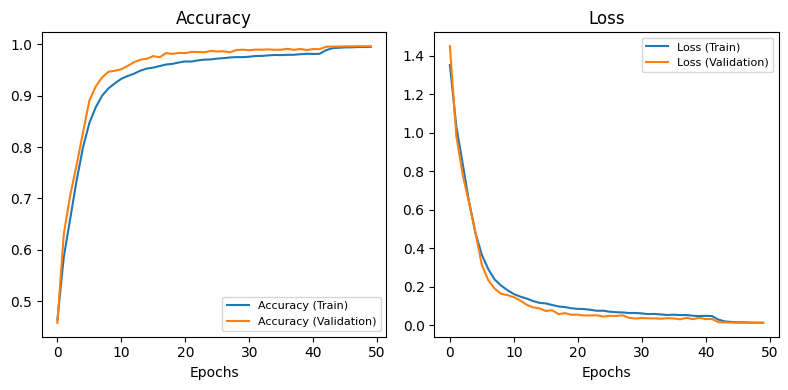

In [7]:
plt.figure(figsize=(8, 4))

# Accuracy plot
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Accuracy (Train)')
plt.plot(history.history['val_accuracy'], label='Accuracy (Validation)')
plt.title('Accuracy')
plt.xlabel('Epochs')
plt.legend(prop={'size': 8})

# Loss plot
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Loss (Train)')
plt.plot(history.history['val_loss'], label='Loss (Validation)')
plt.title('Loss')
plt.xlabel('Epochs')
plt.legend(prop={'size': 8})

plt.tight_layout()
plt.show()

#### Compute evaluation metrics

In [8]:
# Evaluate the model 
test_loss, test_accuracy = model.evaluate(X_test, y_test)

# Retrieve predicted classes
y_pred = model.predict(X_test)  # Predict using the test set
y_pred_classes = np.argmax(y_pred, axis=1)  # Convert predictions to class indices

# Retrieve true labels
y_true = np.argmax(y_test, axis=1)  # Convert true labels to class indices if y_test is one-hot encoded

# Calculate metrics
precision = precision_score(y_true, y_pred_classes, average='weighted')  # Precision
recall = recall_score(y_true, y_pred_classes, average='weighted')        # Recall
f1 = f1_score(y_true, y_pred_classes, average='weighted')                # F1 score

# Print results
print(f"Test Accuracy: {test_accuracy:.4f}")
print(f"Test Loss: {test_loss:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")


1472/1472 [==============================] - 47s 32ms/step
Test Accuracy: 0.9963
Test Loss: 0.0124
Precision: 0.9963
Recall: 0.9963
F1 Score: 0.9963


### Confusion Matrix

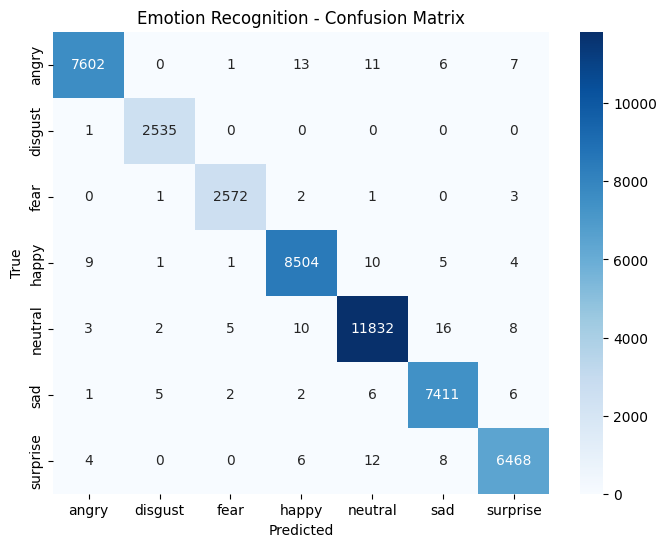

In [9]:
# Confusion Matrix

cm = confusion_matrix(y_true, y_pred_classes)

# Retrieve emotion labels from Emotion column of feature df
label_names = feature_df['Emotion'].unique()

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=label_names, yticklabels=label_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Emotion Recognition - Confusion Matrix')
plt.show()

### Classification report

In [10]:
# Classification report
print(classification_report(y_true, y_pred_classes, target_names=label_names))


              precision    recall  f1-score   support

       angry       1.00      1.00      1.00      7640
     disgust       1.00      1.00      1.00      2536
        fear       1.00      1.00      1.00      2579
       happy       1.00      1.00      1.00      8534
     neutral       1.00      1.00      1.00     11876
         sad       1.00      1.00      1.00      7433
    surprise       1.00      1.00      1.00      6498

    accuracy                           1.00     47096
   macro avg       1.00      1.00      1.00     47096
weighted avg       1.00      1.00      1.00     47096

